In [1]:
import sys
import os
sys.path.append(os.path.abspath("../../src"))

In [2]:
import numpy as np
import torch
import torch.nn.functional as F
import tiktoken
import logging
import json
from time import time
from safetensors import safe_open
from model import FlashSTU
from config import FlashSTUConfig
import torch.nn as nn

# Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


def get_hankel(seq_len: int, use_hankel_L: bool = False) -> np.ndarray:
    entries = np.arange(1, seq_len + 1, dtype=np.float64)
    i_plus_j = entries[:, None] + entries[None, :]

    if use_hankel_L:
        sgn = (-1.0) ** (i_plus_j - 2.0) + 1.0
        denom = (i_plus_j + 3.0) * (i_plus_j - 1.0) * (i_plus_j + 1.0)
        Z = sgn * (8.0 / denom)
    elif not use_hankel_L:
        Z = 2.0 / (i_plus_j**3 - i_plus_j)
    else:
        raise ValueError("use_hankel_L must be a boolean")

    return Z

def get_spectral_filters(
    seq_len: int, 
    K: int, 
    use_hankel_L: bool = False, 
    device: torch.device = None,
    dtype: torch.dtype = torch.float,
) -> torch.Tensor:
    # assert torch.cuda.is_available(), "CUDA is required."
    Z = get_hankel(seq_len, use_hankel_L)
    sigma, phi = np.linalg.eigh(Z)
    sigma_k, phi_k = sigma[-K:], phi[:, -K:]
    phi_k *= sigma_k ** 0.25
    filters = torch.from_numpy(phi_k)
    return filters.to(device=device, dtype=dtype)


/home/ds6237/.conda/envs/torch-env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Unable to import Triton-based MLP: No module named 'liger_kernel'. Falling back to vanilla SwiGLU MLP instead.
Unable to import Triton-based RMSNorm: No module named 'liger_kernel'. Falling back to PyTorch implementation.
Unable to import Triton-based MLP: No module named 'liger_kernel'. Falling back to vanilla SwiGLU MLP instead.
Unable to import Triton-based RMSNorm: No module named 'liger_kernel'. Falling back to PyTorch implementation.
Unable to import Triton-based RMSNorm: No module named 'liger_kernel'. Falling back to PyTorch implementation.
Using device: cuda


In [3]:
K = 20
seq_len = 1024
phi = get_spectral_filters(seq_len, K)

In [8]:
class LDS(nn.Module):
    def __init__(self, state_dim):
        super(LDS, self).__init__()
        self.state_dim = state_dim
        
        self.A = nn.Parameter(torch.randn(state_dim, state_dim) / state_dim)
        self.B = nn.Parameter(torch.randn(1, state_dim) / 1000)
        self.C = nn.Parameter(torch.randn(state_dim, 1) / state_dim)

    def forward(self, seq_len = 1024):
        # Initialize output tensor
        outputs = torch.zeros(seq_len)
        
        # For each position
        for i in range(seq_len):
            # Compute A^i
            a_power = self.A ** i
            
            # Multiply C[:,0] * A^i * B[i]
            outputs[i] = torch.sum(self.C[:,0] * a_power * self.B[0])
            
        return outputs

    def compute_loss(self, filter):
        output = self.forward()
        mse_loss = nn.MSELoss()
        return mse_loss(output, filter)

In [275]:
import torch

def random_LDS(d_h: int, d_o: int, d_u: int, lower_bound: float, delta: float):
    """
    Makes a random LDS with hidden state dimension d_h, observation dimension d_o, and control dimension d_u.
    `lower_bound` is a float in [0, 1] specifying the minimum absolute value for entries in A.
    Each entry in A will be in [lower_bound, 1] multiplied by +/-1 with equal probability.
    Ensures that the spectral radius of A is at most 1 - delta.
    """
    # Generate random values in [lower_bound, 1]
    A = torch.rand(d_h, d_h) * (1 - lower_bound) + lower_bound
    signs = torch.randint(0, 2, (d_h, d_h)) * 2 - 1
    A = A * signs.float()

    # Compute spectral radius
    eigenvalues = torch.linalg.eigvals(A)
    spectral_radius = torch.max(torch.abs(eigenvalues))

    # Scale A if necessary to satisfy spectral radius constraint
    if spectral_radius > 1 - delta:
        A = A * ((1 - delta) / spectral_radius)

    B = torch.randn(d_h, d_u)
    C = torch.randn(d_o, d_h)

    lds = LDS(d_h)
    lds.A.data = A
    lds.B.data = B
    lds.C.data = C  
    return lds


In [300]:
lds = random_LDS(2, 1, 1, 0.999, 0.00001)

In [301]:
from scipy.linalg import orth

In [302]:
vectors = np.array([random_LDS(2, 1, 1, 0.9999, 0.00001)().detach() for _ in range(20)]).T

In [ ]:
basis = orth(vectors)

In [298]:
basis.shape

(1024, 6)

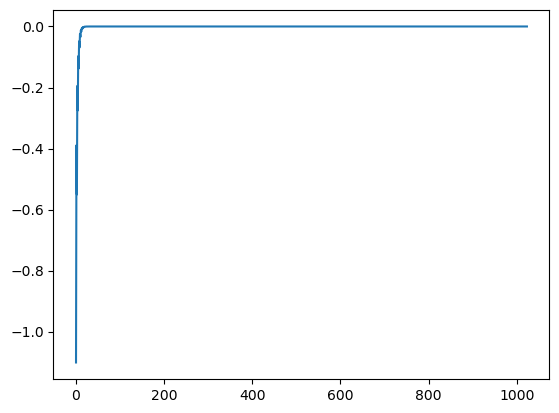

In [299]:
plt.plot(vectors[:,2])

In [240]:
lds().detach().numpy()

array([ 2.0861533, -0.7376703,  1.0424223, ...,  0.       ,  0.       ,
        0.       ], dtype=float32)